# Robustness with respect to parameter perturbations

In [1]:
from model import * 
import numpy as np
from scipy.integrate import odeint



import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})

In [4]:
import pandas as pd 

# Compute randomly sampled basines from 2 fold concentration variation 
def random_basins(x0, parameters, log2_concentation_range=[-1,1], 
                n_points=100, t_max=500,
                     n_time_points=1000, clamped=False):
    
    # Perturbations
    perturbations = 2**np.random.uniform(log2_concentation_range[0], 
                                         log2_concentation_range[1], (4,n_points) ).T * x0
    
    # Time vector
    t = np.linspace(0,t_max,n_time_points)

    # Calculate the trajectories for each of the boundary points
    results = []
    for point in perturbations:
        if clamped:
            result = odeint(equation_clamped,point, t, args=(parameters,))
        else:
            result = odeint(equation,point, t, args=(parameters,))
        results.append(result)

    return t, results

# Compute mean half-life of the L2 norm of the basins of attraction
def compute_t_half(t,basins, x0):
    t_half = []
    for basin in basins:
        # Compute the L2 norm of the basin
        L2_norm = np.linalg.norm(basin-x0, axis=1)
        # Compute the half-life of the L2 norm
        th = np.interp(0.5*L2_norm[0], np.flip(L2_norm), np.flip(t))
        t_half.append(th)

    return np.mean(t_half)

In [5]:
# Perturb parameters one by one 
n = 100
p0 = reference_parameters(concentration_noise=0, flux_noise=0, ki_noise=0)
parameters_perturbed = ['kG', 'kL', 'kF','kR', 'vF0', 'KI_G_L', 'KI_F0_L', 'KI_F0_I','KA_G_I', 'a', 'Imax',]

# Perturb each parameter by the factor in change
def perturb_parameter(p0, p_ix, n=100, t_max=500, mean_t_half_0=10.0):
    result = []
    change = 2**np.random.uniform(-1,1, n)
    for i in range(n):
        p = change_parameters(p0, e=[change[i]], ix=[p_ix], fold_change=True)
        x_inf = steady_state(p, t_max=t_max)

        # Compute basins of attraction
        t, basins = random_basins(x_inf, p, log2_concentation_range=[-1,1], 
                n_points=100, t_max=t_max,
                     n_time_points=1000, clamped=False)
        
        mean_t_half = compute_t_half(t, basins, x_inf)

        result.append({"Parameter":p_ix, "Change":change[i], "G":x_inf[0], "L":x_inf[1],
                       "F":x_inf[2], "I":x_inf[3]/insulin(1,1,0), "tau":mean_t_half/mean_t_half_0}, )
        
    return pd.DataFrame(result)

In [8]:
# Compute reference 
x0 = reference_state(noise=0)
p = reference_parameters(concentration_noise=0, flux_noise=0, ki_noise=0)
t, basins = random_basins(x0, p, log2_concentation_range=[-1,1], 
                n_points=100, t_max=50,
                     n_time_points=1000, clamped=False)

mean_t_half0 = compute_t_half(t, basins, x0)

In [9]:
df_robustness = []

for p_ix in parameters_perturbed:
    df_robustness.append(perturb_parameter(p0, p_ix, n=50, t_max=500, mean_t_half_0=mean_t_half0))

df_robustness = pd.concat(df_robustness)

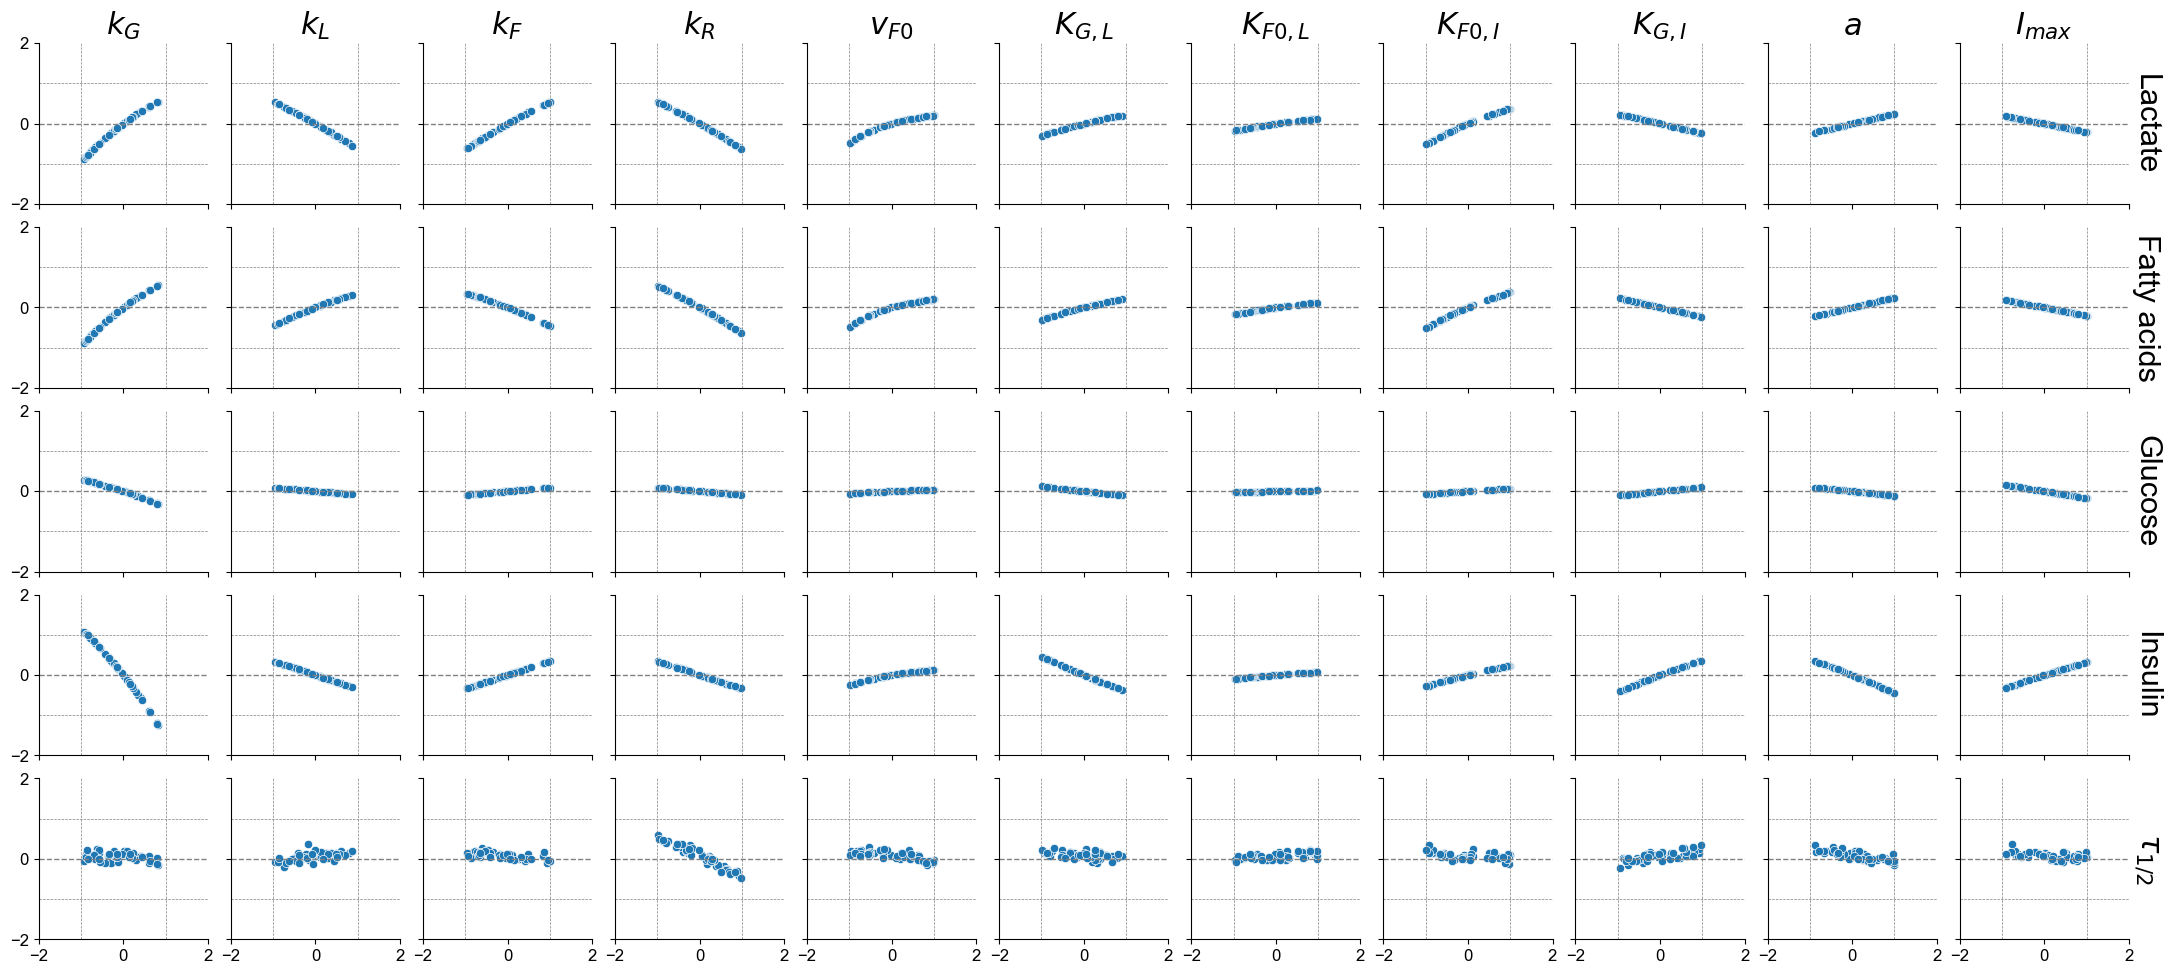

In [11]:
##############################################
# Figure S8 B/C                              #
##############################################

# Set the font size
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})

# Scatter plot each parameter egainst the ouptus = [G, L, F, I, tau]
# Map parameter symbols to names
df_robustness['Symbol'] = df_robustness['Parameter'].replace({'kG':'$k_G$', 'kL':'$k_L$', 'kF':'$k_F$', 'kR':'$k_R$',
                                                                'vF0':'$v_{F0}$', 'vG0':'$v_{G0}$', 'KI_G_L':'$K_{G,L}$',
                                                                'KI_F0_L':'$K_{F0,L}$', 'KI_F0_I':'$K_{F0,I}$', 'KA_G_I':'$K_{G,I}$',
                                                                'Imax':'$I_{max}$', 'a':'$a$'}) 


df_robustness_temp = df_robustness.melt(id_vars=['Symbol','Parameter', 'Change'])
df_robustness_temp['variable'] = df_robustness_temp['variable'].replace({'G':'Glucose', 'L':'Lactate', 
                                                                         'F':'Fatty acids', 'I':'Insulin', 
                                                                         'tau':'$\\tau_{1/2}$'})
df_robustness_temp['log2_fold_value'] = np.log2(df_robustness_temp['value'])
df_robustness_temp['log2_fold_change'] = np.log2(df_robustness_temp['Change'])



g = sns.FacetGrid(df_robustness_temp, row="variable",  col="Symbol", 
                  sharex=True, sharey=True, margin_titles=True, 
                  despine=True, height=2, aspect=1,
                  row_order=[ 'Lactate', 'Fatty acids', 'Glucose', 'Insulin', '$\\tau_{1/2}$'], 
                  col_order=['$k_G$', '$k_L$', '$k_F$', '$k_R$', '$v_{F0}$', '$K_{G,L}$', '$K_{F0,L}$', '$K_{F0,I}$', '$K_{G,I}$','$a$', '$I_{max}$'],
                  )


g.map(sns.scatterplot, "log2_fold_change", "log2_fold_value")
g.refline(y=0, linestyle='--', linewidth=1.0)
g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=22)
g.set(xticks=[-2, 0, 2,], yticks=[-2, 0, 2,])

# Draw a box from -1 to 1 in x and y in very axes
for ax in g.axes.flat:
    ax.axvline(-1, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(1, color='grey', linestyle='--', linewidth=0.5)

plt.savefig('output/robustness.svg')

In [ ]:
##############################################
# Figure S8 D                                #
##############################################

# Make regression plots for the robustness analysis

import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})

# Make a regression plot for kL and the half-life 

f, ax = plt.subplots(1,1, figsize=(4,4))


df_temp = df_robustness.loc[df_robustness["Parameter"] == "kG"]
# Calc fold change in the half-life
df_temp['log2_change'] = np.log2(df_temp['Change'] )
df_temp['log2_tau'] = np.log2(df_temp['tau'] )
df_temp['log2_lactate'] = np.log2(df_temp['L'] )
reg = sns.regplot(data=df_temp, x='log2_change', y='log2_lactate', ax=ax, color='black')

# annotate the slope 
plt.ylim(-1, 1)
plt.xlim(-1, 1)

plt.xlabel('$k_G$ \n ($log_2$ fold change)')
plt.ylabel('Lactate \n ($log_2$ fold change)')

x = reg.get_lines()[0].get_xdata()
y = reg.get_lines()[0].get_ydata()
slope = (y[1]-y[0])/(x[1]-x[0])

plt.text(0.5, 0.75,  '$\\frac{ \Delta log_2 x } { \Delta  log_2 p } =$'+ f" {slope:.2f}", 
         ha='center', va='center', transform=ax.transAxes)

plt.savefig('output/robustness_kL.svg') 

plt.show()

In [12]:


# Compute the slope of the linear regression for each parameter
from scipy.stats import linregress

df_robustness_slope = []

variables = [ 'Lactate', 'Fatty acids', 'Glucose', 'Insulin', '$\\tau_{1/2}$']

for p_ix in parameters_perturbed:
    df_temp = df_robustness_temp.loc[df_robustness_temp['Parameter'] == p_ix]
    for var in variables:
        x = df_temp.loc[df_temp['variable'] == var, 'log2_fold_change']
        y = df_temp.loc[df_temp['variable'] == var, 'log2_fold_value']
        slope, intercept, r_value, p_value, std_err = linregress(x,y)
        df_robustness_slope.append({"Parameter":p_ix, "Variable":var, "Slope":slope, "R2":r_value**2, "p-value":p_value})
    
df_robustness_slope = pd.DataFrame(df_robustness_slope)

df_robustness_slope.head()


,Parameter,Variable,Slope,R2,p-value
0,kG,Lactate,0.825707,0.990853,1.355465e-50
1,kG,Fatty acids,0.825707,0.990853,1.355465e-50
2,kG,Glucose,-0.337522,0.995383,1.008224e-57
3,kG,Insulin,-1.298954,0.994173,2.694774e-55
4,kG,$\tau_{1/2}$,-0.050760,0.078357,4.896979e-02


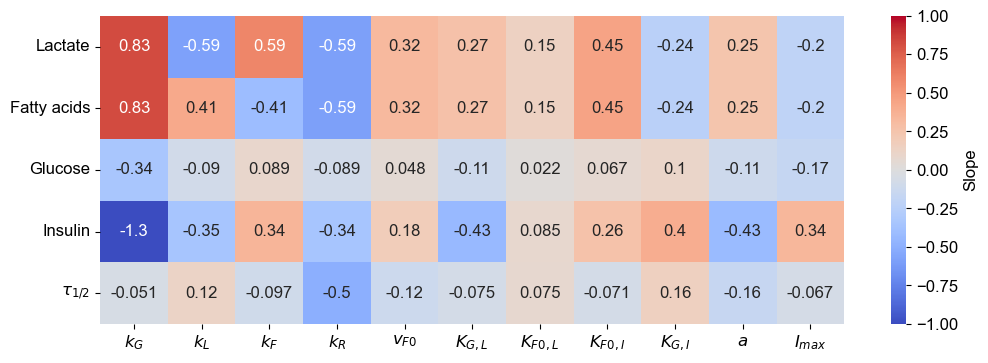

In [13]:
##############################################
# Figure S8 E                                #
##############################################

# Make a heatmap of the slopes
df_robustness_slope_pivot = df_robustness_slope.pivot(index='Parameter', columns='Variable', values='Slope')

# Change to order of the columns and row to match the plot above 
df_robustness_slope_pivot = df_robustness_slope_pivot[['Lactate', 'Fatty acids', 'Glucose', 'Insulin', '$\\tau_{1/2}$']]
df_robustness_slope_pivot = df_robustness_slope_pivot.reindex(['kG', 'kL', 'kF', 'kR', 'vF0', 'KI_G_L', 'KI_F0_L', 'KI_F0_I', 'KA_G_I', 'a' ,'Imax'])
# Rename the rows to parameter symbols 
df_robustness_slope_pivot.index = df_robustness_slope_pivot.index.map({'kG':'$k_G$', 'kL':'$k_L$', 'kF':'$k_F$', 'kR':'$k_R$',
                                                                'vF0':'$v_{F0}$', 'vG0':'$v_{G0}$', 'KI_G_L':'$K_{G,L}$',
                                                                'KI_F0_L':'$K_{F0,L}$', 'KI_F0_I':'$K_{F0,I}$', 'KA_G_I':'$K_{G,I}$',
                                                                'Imax':'$I_{max}$', "a":'$a$'})    

plt.figure(figsize=(12,4))
sns.heatmap(df_robustness_slope_pivot.T, annot=True, cmap='coolwarm', cbar_kws={'label': 'Slope'}, vmin=-1, vmax=1)

plt.xlabel('')
plt.ylabel('')

plt.yticks(rotation=0)
plt.xticks(rotation=0, ha='center')

plt.savefig('output/robustness_slope.svg')

plt.show()